# DBscan and HDBscan with KMeans as a baseline

DBscan example derived from <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py">Demo of DBSCAN clustering algorithm</a>

In [1]:
#take care of necessary installs
#!pip install kneed
#!pip install hdbscan
# !git clone https://github.com/CNUClasses/utils

In [2]:
#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.datasets as data
from sklearn.preprocessing import StandardScaler
    
import utils as ut


# Constants and Functions

In [5]:
NSAMPLES=300
RANDOM_STATE=999
MIN_SAMPLES = 6  #this is the number of points that must be within eps for a point to be considered a core point, including the point itself
from sklearn.neighbors import NearestNeighbors
def get_sorted_distances( X, min_samples=MIN_SAMPLES):
    '''
    X:data 
    distances: the sorted distances to MIN_SAMPLES points for every point in X
    plot: to plot the knee or not
    return: sorted distances in descending order
    '''
    nbrs = NearestNeighbors(n_neighbors=min_samples ).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distance_descending = sorted(distances[:,min_samples-1], reverse=True)
    return distance_descending


#kneed is not part of scikitlearn or a standard anaconda distribution, here is how to install
# !conda install -c conda-forge kneed -y
from kneed import KneeLocator
def get_eps(X,distances, plot=False):
    '''
    X:data 
    distances: the sorted distances toMIN_SAMPLES points for every point in X
    plot: to plot the knee or not
    return: eps
    '''
    kneedle = KneeLocator(range(1,len(X)+1),  #x values
                      distances, # y values
                      S=1.0, #sensitivity
                      curve="convex", 
                      direction="decreasing") #parameter from figure
    if(plot):
        kneedle.plot_knee()
    eps=kneedle.knee_y  # optimum value for eps
    # kneedle.elbow
    # kneedle.knee
    return eps


def display_cluster_info(fitted_estimator,X, misclassified_indices=None):
    '''
    fitted_estimator: an estimator that has been fitted to data
    X: data that estimator was fitted to
    return: number of clusters and cluster_labels
    '''
    #cluster labels for dataset
    cluster_labels = fitted_estimator.labels_

    if(misclassified_indices is not None):
        cluster_labels[misclassified_indices] = -2
        print("Estimated number of misclassified indices: %d" % len(misclassified_indices))

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters)
    print("Estimated number of noise points: %d" % n_noise_)

    sns.scatterplot(x=X[:,0], y=X[:,1],hue=cluster_labels, palette=ut.colors1)
 
    return n_clusters,cluster_labels

# Generate a dataset

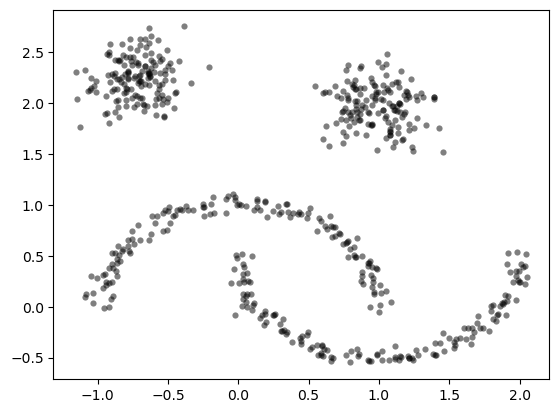

In [7]:
#this generates a dataset with blobs and moons
moons, _ = data.make_moons(n_samples=NSAMPLES, noise=0.05)
blobs, _ = data.make_blobs(n_samples=NSAMPLES, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.2)
X = np.vstack([moons, blobs])
plot_kwds = {'alpha' : 0.5, 's' : 20, 'linewidths':0}
plt.scatter(X.T[0], X.T[1], color='black', **plot_kwds);

# kmeans (baseline performance)

Estimated number of clusters: 4
Estimated number of noise points: 0


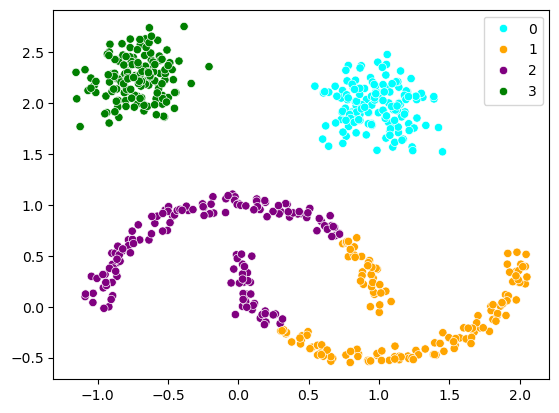

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=RANDOM_STATE).fit(X)
n_clusters,cluster_labels=display_cluster_info(kmeans,X);

# DBscan

Parameters of Interest:
    
   <u>eps (radius)</u>- The maximum distance between two samples for one to be considered in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set since it determines density (ie smaller eps means core points must have surrounding points closer in order to be a core point) <br>
    <u>min_samples</u> - The minimum number of samples within eps of a point for that point to be considered a core point. This includes the point itself.
    
## Guess min_samples
Its hard to choose this one. <mark>Without specialized knowledge, arbitrary rule of thumb is to choose 2*(numb_features+1)


In [9]:
MIN_SAMPLES = 5

## Try to find a good eps for above min_samples
We do this in 2 steps, first decide on min_samples (number of sample) <br>
1. Calculate the distances to MIN_SAMPLES for every point in the dataset, then sort the results in descending order. Some of these points will be in a high density area (core and non-core points), so the average MIN_SAMPLES distances will be smaller, others will be in a low density area (outliers), so the average MIN_SAMPLES will be larger<br>
2. Find where the average distances starts growing the fastest.  Draw a vertical line through this point.  Any eps to the left is a distance large enough that it risks erroneously merging distinct clusters together.


### Method 1
Eyeball the line graph below, find point of maximum curvature, eps= the value of Y at that point.

In [10]:
import plotly.express as px

distance_descending=get_sorted_distances( X,min_samples=MIN_SAMPLES)
px.line(x=list(range(1,len(distance_descending )+1)),y= distance_descending,labels={'x':'Points','y':'Distance'},title='Knee Point')


### Method 2: Automate eps search with kneed
Parameters defined <a href="https://kneed.readthedocs.io/en/stable/parameters.html#curve">here</a><br>
Given x and y arrays, kneed attempts to identify the knee/elbow point of a line fit to the data. <mark>The knee/elbow is defined as the point of the line with maximum curvature. 

The best eps=0.12204582271679518


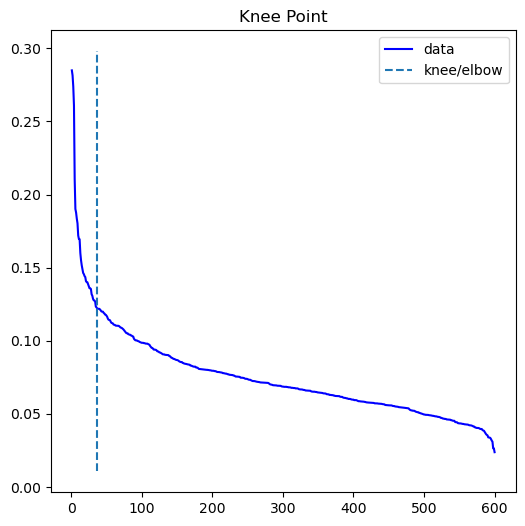

In [11]:
distance_descending=get_sorted_distances( X,min_samples=MIN_SAMPLES)
eps=get_eps(X,distance_descending, plot=True)
print(f'The best eps={eps}')

## Run algorithm 
Have min_samples and a calculated eps that works well for this dataset and min_samples

Estimated number of clusters: 5
Estimated number of noise points: 9


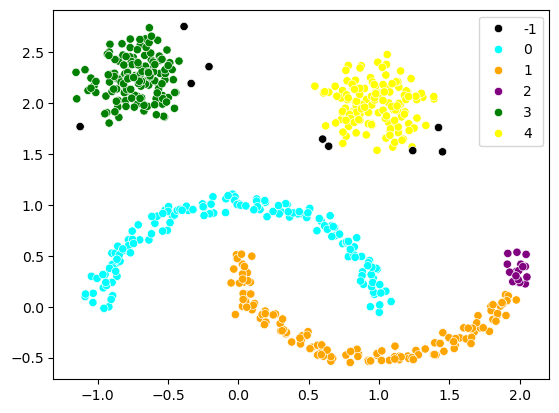

In [12]:

distance_descending=get_sorted_distances( X,min_samples=MIN_SAMPLES)
eps=get_eps(X,distance_descending)

db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES).fit(X)
n_clusters,cluster_labels=display_cluster_info(db,X);

# HDBscan

Estimated number of clusters: 4
Estimated number of noise points: 0


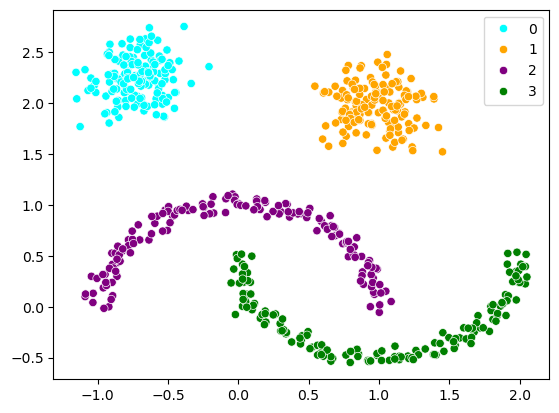

In [13]:
#hdbscan is not part of scikitlearn or a standard anaconda distribution, here is how to install
# !conda install -c conda-forge hdbscan -y

import hdbscan

#whats a good minimum cluster size? Another hyperparameter to guess
MIN_CLUSTER_SIZE=100
db = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES).fit(X)
n_clusters,cluster_labels=display_cluster_info(db,X);
plt.show()

# Sounds great right, try it with overlapping centers (), In section 3 above change cluster_std from .4 to .5

This makes it so cluster points will get a little closer to each other. DBscan just lumps everything into 1 cluster, HDBscan does a bit better, but we do have a  bunch of outliers.<br>
The moral: prefer HDBscan over DBscan. When there is cluster overlap both algorithms start to lose the ability to distinguish between clusters

# Lets check the silhouette score for each algorithm
Run the above algorithm for both DBscan and HDBscan and see what the silhouette scores are
BTW these are very useful when you have high dimensional data so that you cant plot and visually confirm cluster membership

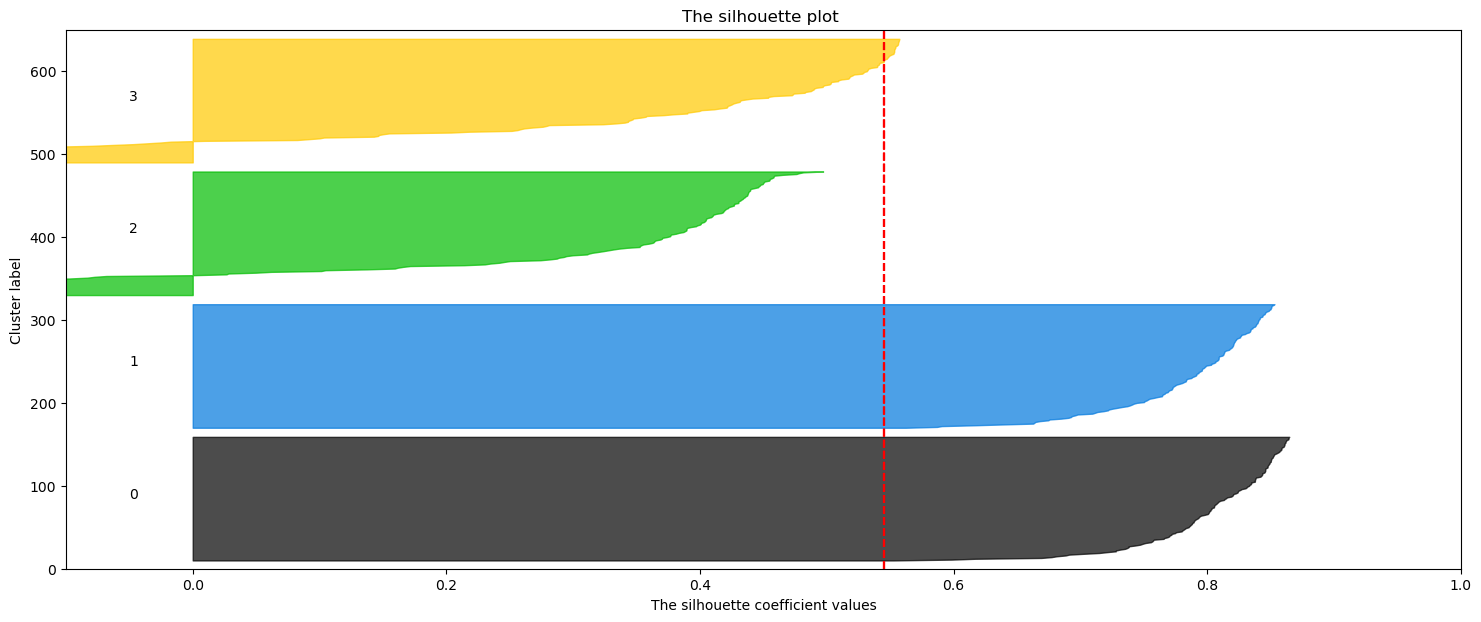

In [14]:
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

#find the indices where sil score is <=0 use this to go back and label possibly misclassified points
misclassified_indices = np.where(sample_silhouette_values <= 0)[0]
# Remove indices in misclassified_indices that are set to -1 in cluster_labels
misclassified_indices = misclassified_indices[cluster_labels[misclassified_indices] != -1]
#noise points are going to have sil score <=0, but dont indicate they are misclassified

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i));

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot ");
    ax1.set_xlabel("The silhouette coefficient values");
    ax1.set_ylabel("Cluster label");

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--");
plt.show();


Estimated number of misclassified indices: 50
Estimated number of clusters: 5
Estimated number of noise points: 0


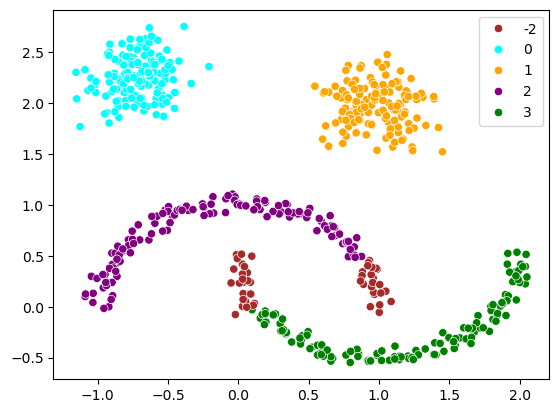

In [15]:
#if any misclassified run this to see the misclassified points
display_cluster_info(db,X, misclassified_indices);
plt.show()